### 1. Importing and Loading Required Libraries

#### 1.1. Installing and Loading Required Packages
This section installs and loads the essential R packages for data analysis and visualization. The `ggcorrplot` package creates correlation plots, `car` offers regression diagnostics, and `HH` provides additional statistical methods. The `tidyverse` is used for data manipulation, `ggplot2` for visualization, and both `gridExtra` and `cowplot` help arrange multiple plots.

In [298]:
install.packages("ggcorrplot")
install.packages("car")
install.packages("HH")
# Load necessary libraries
library(tidyverse)
library(ggplot2)
library(gridExtra)
library(cowplot)
library(ggcorrplot)
library(car)
library(HH)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### 2. Data Preparation and Transformation

#### 2.1. Reading the Data
Reading the data from the CSV file and displaying the first few rows to understand the structure of the data.

In [299]:
data_rent <- read.csv("/Users/karimmbk/Documents/halef-thesis/web-scraper/resources/clean-data/rent_2018_2021.csv", dec = ",", header = TRUE, sep = ";")

#### 2.2. Convert categorical variables to factors (dummy variables)
Converting categorical variables to factors to use them in the regression model.

In [300]:
data_rent$gym <- as.factor(data_rent$gym)
data_rent$field_quadra <- as.factor(data_rent$field_quadra)
data_rent$elevator <- as.factor(data_rent$elevator)
data_rent$furnished <- as.factor(data_rent$furnished)
data_rent$swimming_pool <- as.factor(data_rent$swimming_pool)

#### 2.3. Convert date to date format
Converting the date column to a date format to filter the data by year.

In [301]:
data_rent$date <- as.Date(data_rent$date, format = "%d/%m/%Y")

### 3. Model Specification and Fitting
 Analyzing the correlation between the variables to understand the relationship between them.

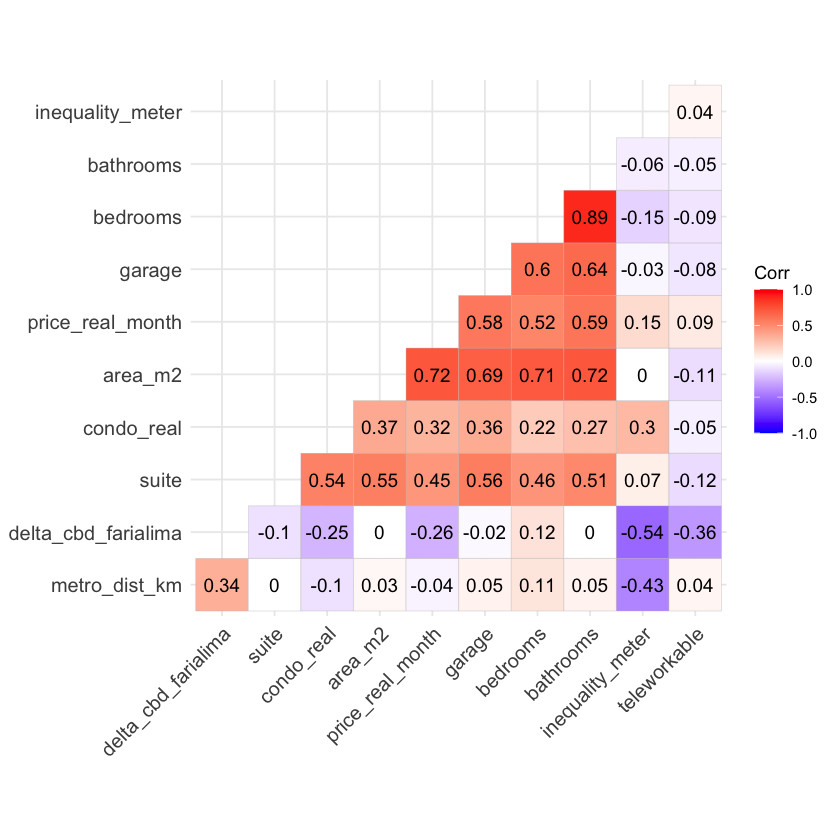

In [302]:
corr_data <- data_rent[, (names(data_rent) %in% c("price_real_month", "area_m2", "bedrooms", "bathrooms", "garage", "condo_real", "metro_dist_km", "delta_cbd_farialima", "teleworkable", "inequality_meter", "suite"))]

# Compute correlation at 2 decimal places
corr_matrix <- round(cor(corr_data), 2)
ggcorrplot(corr_matrix, hc.order = TRUE, type = "lower", lab = TRUE)

#### 3.1. Defining the Model parameters
This subsection defines the formula for the regression model, specifying `price_m2` as the dependent variable and various property features as independent variables.

In [303]:
params <- (price_real_month ~ area_m2 +
  bedrooms +
  metro_dist_km +
  delta_cbd_farialima +
  inequality_meter +
  teleworkable +
  garage +
  gym +
  field_quadra +
  elevator +
  furnished +
  swimming_pool)

reg <- lm(params, data = data_rent)

#### 3.3 Checking the results for the linear regression model
Checking the results for the linear regression model to understand the relationship between the variables.

In [304]:
summary(reg)


Call:
lm(formula = params, data = data_rent)

Residuals:
    Min      1Q  Median      3Q     Max 
-6554.2  -709.9  -152.1   519.9 13052.0 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -318.5723   153.5290  -2.075  0.03802 *  
area_m2               29.2963     0.6316  46.385  < 2e-16 ***
bedrooms            -326.6958    28.9747 -11.275  < 2e-16 ***
metro_dist_km         21.0706    12.5653   1.677  0.09361 .  
delta_cbd_farialima -106.7601     5.5911 -19.095  < 2e-16 ***
inequality_meter      21.5502     2.0226  10.655  < 2e-16 ***
teleworkable        1766.0354   172.4334  10.242  < 2e-16 ***
garage               643.7296    29.1712  22.067  < 2e-16 ***
gym1                 284.5316    88.5791   3.212  0.00132 ** 
field_quadra1         61.1132    74.4237   0.821  0.41159    
elevator1           -150.4792    60.3170  -2.495  0.01262 *  
furnished1           366.9596    62.9454   5.830 5.78e-09 ***
swimming_pool1      -127.6390    90.026

### 4. Finding the best model
Creating a code to run the best model and generate the best combination of variables and transformations to generate the final regression model.

#### 4.1 Function to calculate the best model
The function `calculate_best_model` calculates the best model by generating all possible combinations of transformations for the independent variables. The function returns the best model, the best combination of variables and transformations, and the best R² value.

In [306]:
calculate_best_model <- function(data, dependent_var, independent_vars, transformations) {
  best_r2 <- -Inf
  best_model <- NULL
  best_combination <- NULL
  list_r2 <- NULL

  # Gerar todas as combinações de transformações para todas as variáveis independentes
  trans_combinations <- expand.grid(rep(list(transformations), length(independent_vars)))
  colnames(trans_combinations) <- independent_vars

  for (trans_row in seq_len(nrow(trans_combinations))) {
    transformed_data <- data
    formula_parts <- c(dependent_var, "~")
    for (var in independent_vars) {
      trans <- trans_combinations[trans_row, var]
      transformed_var <- switch(as.character(trans),
                                "X" = data[[var]],
                                "1_X" = 1 / data[[var]],
                                "LnX" = log(data[[var]]),
                                "X__2" = data[[var]]^2,
                                "X__1_2" = sqrt(data[[var]]),
                                "1_X__2" = 1 / (data[[var]]^2),
                                "1_X__1_2" = 1 / sqrt(data[[var]]))
      trans_name <- paste(var, trans, sep = "_")
      transformed_data[[trans_name]] <- transformed_var
      formula_parts <- c(formula_parts, trans_name)
    }

    formula_string <- paste(paste(formula_parts, collapse = " + "), " + garage + gym + field_quadra + elevator + furnished + swimming_pool")
    formula_string <- gsub(" \\+ ~ \\+ ", " ~ ", formula_string)  # Corrigir formatação da fórmula
    formula <- as.formula(formula_string)
    model <- lm(formula, data = transformed_data)

    r2 <- summary(model)$r.squared
    list_r2 <- append(list_r2, r2)

    if (r2 > best_r2) {
      best_r2 <- r2
      best_model <- model
      best_combination <- list(variables = independent_vars, transformations = as.list(trans_combinations[trans_row,]))
    }
  }
  return(list(best_model = best_model, best_combination = best_combination, best_r2 = best_r2, list_r2 = list_r2))
}

#### 4.2 Defining the variables to be used in the model
Defining the dependent and independent variables and transformations to be used in the model.

In [307]:
data_rent$price_real_month <- log(data_rent$price_real_month)
dependent_var <- "price_real_month"
independent_vars <- c("area_m2", "bedrooms", "metro_dist_km", "delta_cbd_farialima", "inequality_meter", "teleworkable")
transformations <- c("X", "1_X", "LnX", "X__2", "X__1_2", "1_X__2", "1_X__1_2")

#### 4.3 Calculating the function to generate the best model
Running the function to generate the best model and print the results.

In [308]:
results <- calculate_best_model(data_rent, dependent_var, independent_vars, transformations)

#### 4.4 Printing the result
Printing the best model, the best combination of variables and transformations, and the best R² value.

In [309]:
summary(results$best_model)


Call:
lm(formula = formula, data = transformed_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.45361 -0.23287 -0.02186  0.23270  1.36245 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 6.444166   0.066819  96.443  < 2e-16 ***
area_m2_LnX                 0.659591   0.013171  50.081  < 2e-16 ***
bedrooms_X                 -0.096087   0.008198 -11.721  < 2e-16 ***
metro_dist_km_X__1_2       -0.110151   0.009177 -12.003  < 2e-16 ***
delta_cbd_farialima_X__1_2 -0.209648   0.007079 -29.616  < 2e-16 ***
inequality_meter_1_X__1_2  -4.525500   0.418609 -10.811  < 2e-16 ***
teleworkable_1_X__1_2      -0.092740   0.009385  -9.882  < 2e-16 ***
garage                      0.207380   0.007881  26.314  < 2e-16 ***
gym1                        0.115074   0.024040   4.787 1.73e-06 ***
field_quadra1               0.013252   0.020193   0.656  0.51167    
elevator1                  -0.048081   0.016392  -2.933  0.00337 ** 

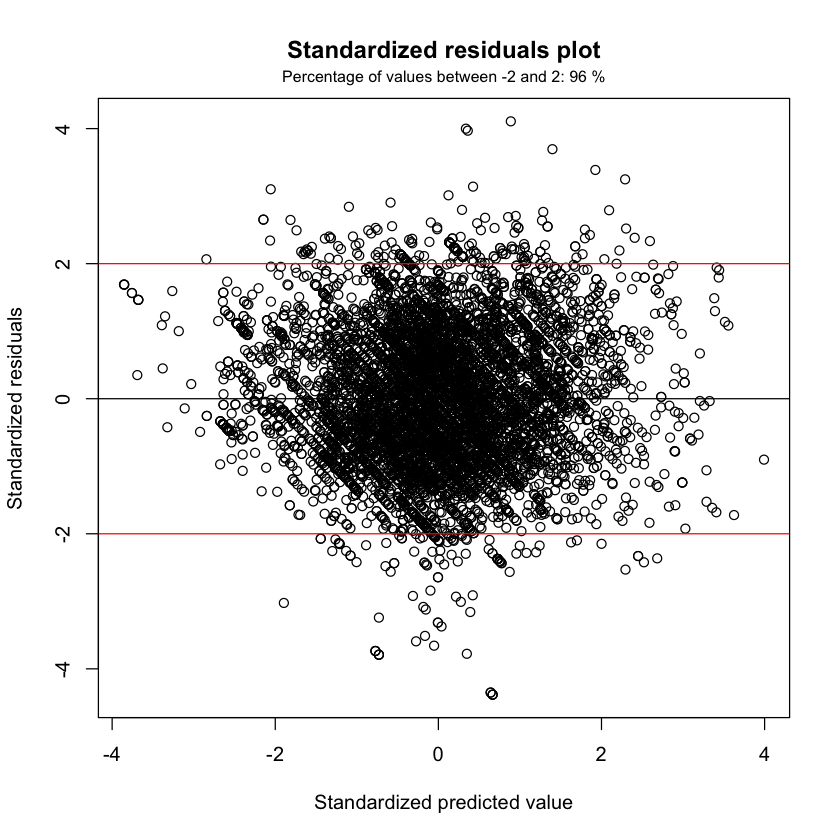

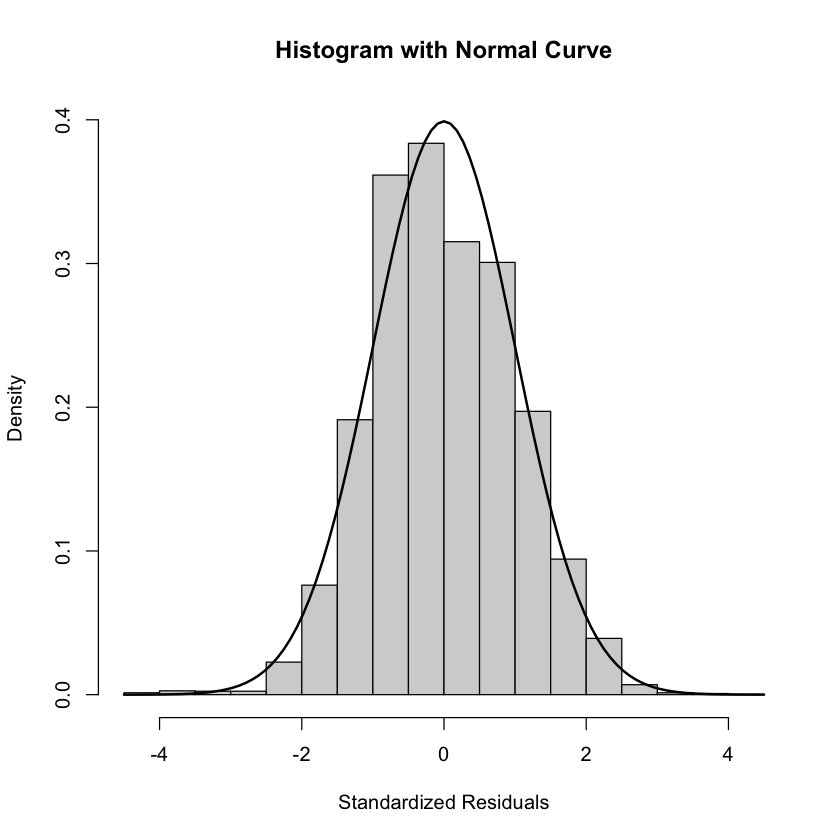

In [320]:
predicted<- predict(results$best_model)
residuals <- resid(results$best_model)
stand_predicted <- (predicted - mean(predicted)) / sd(predicted)
stand_residuals <- (residuals - mean(residuals)) / sd(residuals)

plot(stand_predicted, stand_residuals, main = "Standardized residuals plot", xlab = "Standardized predicted value", ylab = "Standardized residuals")
abline(0, 0)
abline(h = -2, col = "red")
abline(h = 2, col = "red")

# Calculate the total number of values within the interval [-2, 2]
within_interval <- sum(stand_residuals >= -2 & stand_residuals <= 2)
mtext(paste("Percentage of values between -2 and 2:", round(within_interval / length(stand_residuals) * 100, 2), "%"), side = 3, line = 0.5, cex = 0.8)

# Calculate the histogram data without plotting
hist_data <- hist(stand_residuals, plot = FALSE)

# Calculate the normal distribution density values
x_values <- seq(min(stand_residuals), max(stand_residuals), length = 100)
y_values <- dnorm(x_values, mean = mean(stand_residuals), sd = sd(stand_residuals))

# Determine the y-axis limit
y_max <- max(c(hist_data$density, y_values))

# Plot the histogram with the y-axis limit
hist(stand_residuals, freq = FALSE, ylim = c(0, y_max),
     main = "Histogram with Normal Curve", xlab = "Standardized Residuals")

# Add the normal distribution curve
curve(dnorm(x, mean = mean(stand_residuals), sd = sd(stand_residuals)), add = TRUE, lwd = 2)